<b/>PHYS40591/64591 RADIO ASTRONOMY 2015

Dicke Switch Example</b>




----------------------------------------------------------------------------

<i/>This notebook illustrates the suppression of absolute gain variations produced by using a Dicke Switch Receiver. </i>

You can use it to vary the effect of various parameters, such as:

- the switching frequency;

- the "balance" of your switch, i.e. the temperature difference between $T_{\rm ant}$ and $T_{\rm load}$;

- the time averaging of your signal


etc

In [1]:
%matplotlib inline

import pylab as pl
import numpy as np
import scipy as sp
from scipy import signal

Let us start by assuming a system with a receiver temperature of $T_{\rm rec} = 180$ K, observing a patch of sky which gives an antenna temperature of $T_{\rm ant} = 10$ K.

In [2]:
t_rec = 180.    # K
t_ant = 10.     # K

We assume that the effective gain of the system is $G=1$ (really it would be more like 1000), which has a variation of $\Delta G = g_0 + g_1 \tau$ (see Lecture 11&12 Worked Example 7), where $g_1 = 10^{-6}$ seconds and $g_0 = 0$. 

The power measured by the system will be

$$[G +\Delta G(t)]k_{\rm B} T_{\rm sys} \Delta \nu.$$

We can re-arrange this to emphasise the fake signal component:

$$G\left[1+\frac{\Delta G}{G}\right]T_{\rm sys} k_{\rm B}\Delta \nu = G\left[T_{\rm sys} + \frac{\Delta G}{G}T_{\rm sys}\right] k_{\rm B} \Delta \nu = G\left[T_{\rm sys} + \Delta T \right] k_{\rm B} \Delta \nu,$$

where, $\Delta T = \frac{\Delta G}{G}T_{\rm sys}$.

But the signals that travel through the system are not simply temperatures, but rather the voltage produced by a signal with a given power, which is proportional to temperature:

$$\langle V^2 \rangle^{0.5} = (4k_{\rm B}TR\Delta \nu)^{0.5} = a\cdot T^{0.5}.$$

In what follows we're just going to set $a=1$.

------------------------------------------------------------------------------------------

Let's initially consider the case of the <b/>basic radiometer</b>:

Here our system temperature is the sum of the receiver temperature and the antenna temperature, so

$$T_{\rm rec} + T_{\rm ant} = T_{\rm sys} = \langle V_{\rm sys}^2 \rangle = \langle [V_{\rm rec} + V_{\rm ant}]^2 \rangle.$$

Before the first LNA, we have the contribution from the antenna temperature and the contribution from the LNA and we're going to sample it every 1 millisecond:

In [3]:
# array of time samples:
t_sample = 0.001    # seconds
t = np.arange(0.,1000.,t_sample)

# voltage from receiver temperature:
sig = t_rec**0.5
v_rec = np.random.normal(0,sig,size=len(t))

# voltage from antenna temperature:
sig = t_ant**0.5
v_ant = np.random.normal(0,sig,size=len(t))

v_sys = v_rec + v_ant

#pl.subplot(111)
#pl.title("Voltage Input to LNA")
#pl.plot(t,v_sys)
#pl.show()

This voltage is passed through the LNA, which has the gain variation stated above:

In [4]:
# add in the time variable gain:
g = 1.
g0 = 0.0; g1 = 1e-4
delta_g = g0 + g1*t

v_out = v_sys*(g + delta_g)

#pl.subplot(111)
#pl.title("Voltage Output from LNA")
#pl.plot(t,v_out)
#pl.show()

We then Square Law detect...

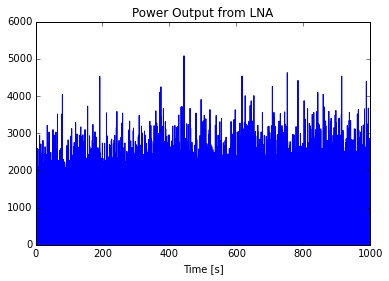

In [5]:
p_sys = v_out**2

pl.subplot(111)
pl.title("Power Output from LNA")
pl.plot(t,p_sys)
pl.xlabel("Time [s]")
pl.show()

...and average. To do this we define an averaging interval and just convolve our signal with a top-hat window function of that size:

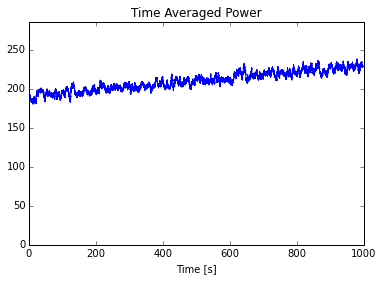

In [6]:
# averaging function:
def window(size):
    return np.ones(size)/float(size)

size = 5000    # samples, not seconds
p_av = np.convolve(p_sys,window(size),'same')


pl.subplot(111)
pl.title("Time Averaged Power")
pl.plot(t[size/2:-size/2], p_av[size/2:-size/2])
pl.axis([0,1000.,0.,1.2*np.max(p_av)])
pl.xlabel("Time [s]")
pl.show()

<b/> Q:</b> Can you see the drift from the gain variation?

<b/> Q:</b> What is the absolute variation in the output signal due to the gain variation?


------------------------------------------------------------------------------------------


Now let's look at the corresponding output for a <b/>Dicke switched system</b>.

We'll assume that the load reference has a load temperature, $T_{\rm load}$, of 77K:

In [7]:
t_load = 77.    # K

First let's propagate the voltages from our two different switch positions, 1 & 2:

In [8]:
# voltage from load temperature:
sig = t_load**0.5
v_load = np.random.normal(0,sig,size=len(t))

v_sys_1 = v_rec + v_ant
v_sys_2 = v_rec + v_load

Then we need to set up the switching for the rest of the signal path.

We need to pick a switching period, $t_{\rm switch}$:

Switching at:  0.1  Hz


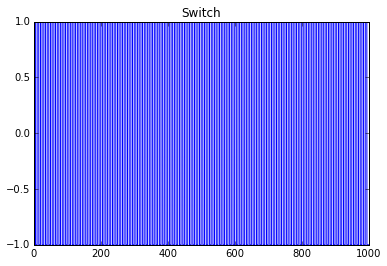

In [9]:
t_switch = 10.             # seconds
f_switch = 1./t_switch     # Hz
print "Switching at: ",f_switch," Hz"

switch = signal.square(2 * np.pi * f_switch * t)

pl.subplot(111)
pl.title("Switch")
pl.plot(t,switch)
pl.show()

<b/> Q:</b>  Can't see anything? If you want to see the switching you'll need to increase the period of the switch - otherwise it's changing too fast to see on the plot!



Allocate the two input signals varying according to the switch:

In [10]:
v_sys = np.ones(len(t))
v_sys[np.where(switch==1)] = v_sys_2[np.where(switch==1)]
v_sys[np.where(switch==-1)] = v_sys_1[np.where(switch==-1)]

This is then passed through the LNA:

In [11]:
v_dke = v_sys*(g + delta_g)

Then use a square law detector:

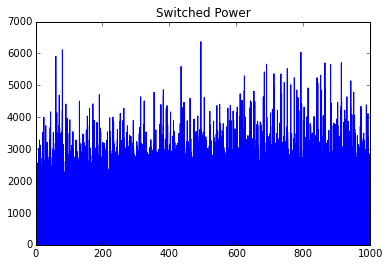

In [12]:
p_dke = v_dke**2

pl.subplot(111)
pl.title("Switched Power")
pl.plot(t,p_dke)
pl.show()

Add in the +1 vs. -1 multiplication from the synchronous detection of the switch:

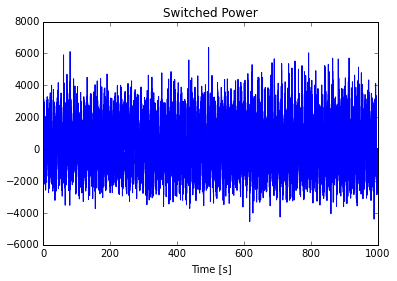

In [13]:
p_sys = np.ones(len(t))
p_sys[np.where(switch==1)] = +1*p_dke[np.where(switch==1)]
p_sys[np.where(switch==-1)] = -1*p_dke[np.where(switch==-1)]

pl.subplot(111)
pl.title("Switched Power")
pl.xlabel("Time [s]")
pl.plot(t,p_sys)
pl.show()

(  If we average this up a little bit we can see the signal better:

Averaging over a period of  1.0  seconds ( 1000  samples)


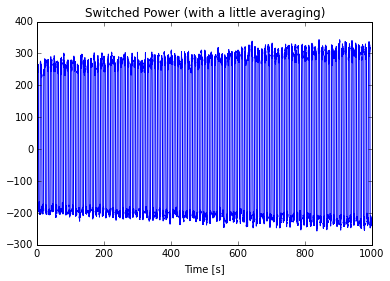

In [14]:
t_av = 0.1*t_switch
size = int(t_av/t_sample)  # samples, not seconds
print "Averaging over a period of ",size*t_sample," seconds (", size," samples)"
p_av = np.convolve(p_sys,window(size),'same')

pl.subplot(111)
pl.title("Switched Power (with a little averaging)")
pl.xlabel("Time [s]")
pl.plot(t[size/2:-size/2], p_av[size/2:-size/2])
pl.show()

  Can you see what you expect in the power output?  )

Average over many $t_{\rm switch}$ periods:

(<i/>Note: this convolution takes a little while to run...</i>)

Averaging over a period of  100.0  seconds  ( 100000  samples)


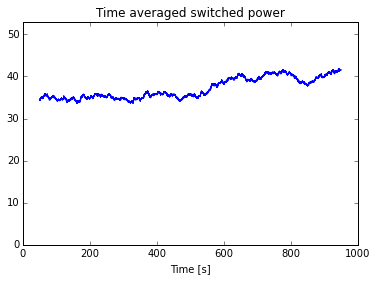

In [15]:
t_av = 10.*t_switch
size = int(t_av/t_sample)
print "Averaging over a period of ",size*t_sample," seconds  (", size," samples)"
p_av = np.convolve(p_sys,window(size),'same')

pl.subplot(111)
pl.title("Time averaged switched power")
pl.plot(t[size/2:-size/2], p_av[size/2:-size/2])
pl.axis([0.,1000.,min(0.,1.1*np.min(p_av)),1.2*np.max(p_av)])
pl.xlabel("Time [s]")
pl.show()

<b/> Q:</b> Can you see the drift from the gain variation?

<b/> Q:</b> What is the absolute variation in the output signal due to the gain variation?


Let's calculate the mean value of the output power:

In [16]:
p_mean = p_av.mean()
print "Output Power: ",p_mean

Output Power:  36.213804178


<b/> Q:</b> Is this what you were expecting?